# 2023-08-05__AdEx_Nto1_we_sweep

(We've made Nto1AdEx.jl now).

Let's do an unholy python julia brian hybrid.

(plotting (and nb restarting) in julia still too slow startup).  
But sim is almost 1000x faster than brian.

In [1]:
%%time
from brian2.units import *

CPU times: total: 984 ms
Wall time: 2.7 s


In [2]:
%%time
%run lib/plot.py

Importing mpl, brian … ✔
CPU times: total: 0 ns
Wall time: 18.8 ms


https://github.com/JuliaPy/pyjulia

In [3]:
%%time
from julia import Pkg

CPU times: total: 3.16 s
Wall time: 5.34 s


In [4]:
%%time
Pkg.activate("..")
# Pkg.status()
# output is in nb terminal

CPU times: total: 1.03 s
Wall time: 2.26 s


In [5]:
%%time
from julia import Nto1AdEx

CPU times: total: 516 ms
Wall time: 1.19 s


In [6]:
%%time
out = Nto1AdEx.sim(6500, 10);

CPU times: total: 375 ms
Wall time: 1.15 s


(First run: 1.3 seconds)

In [7]:
V = (out.V * volt)

array([-65.        , -64.99986538, -64.99623327, ..., -54.53301958,
       -54.51563329, -54.49719995]) * mvolt

In [8]:
%run lib/util.py

Importing mpl, brian … ✔
Importing pandas … ✔


In [9]:
V = ceil_spikes_jl(out)

array([-65.        , -64.99986538, -64.99623327, ..., -54.53301958,
       -54.51563329, -54.49719995]) * mvolt

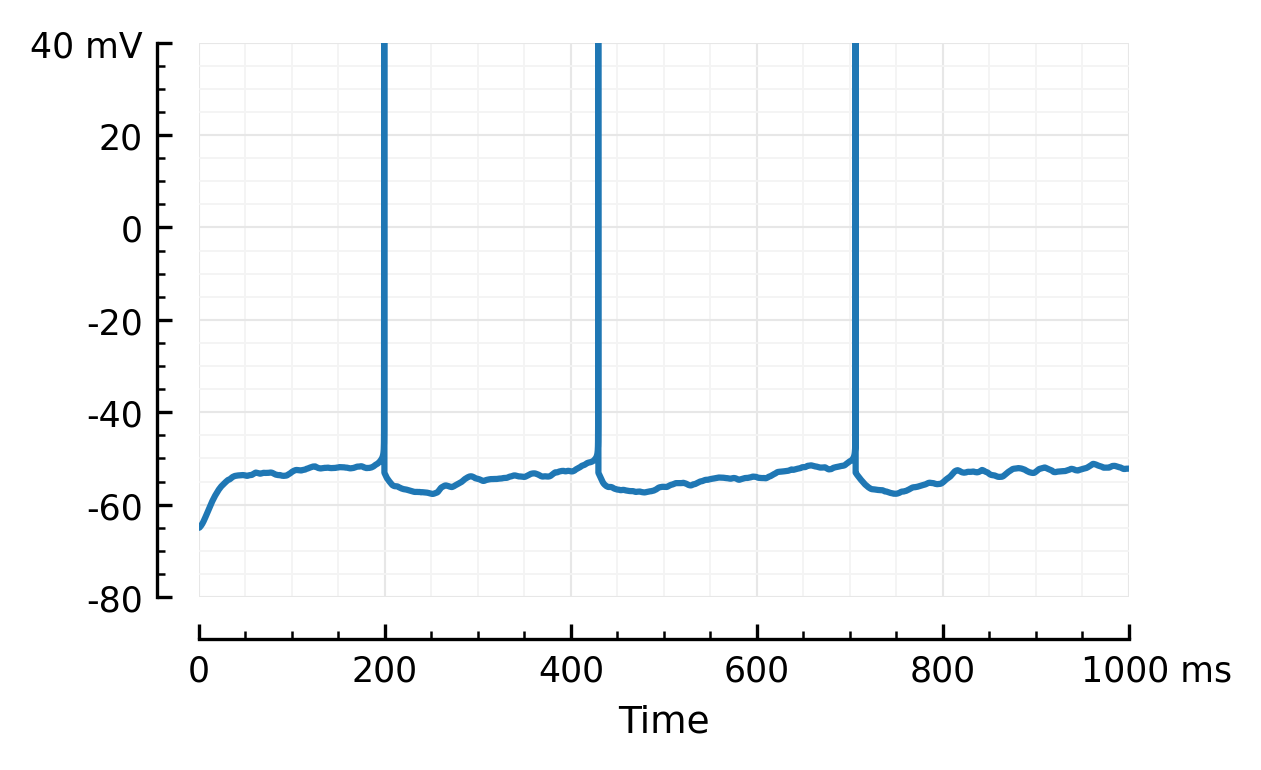

In [10]:
plotsig(V, tlim=[0,1000]*ms);

In [11]:
%run lib/diskcache.py

In [12]:
N = 6500
T = 10 * second

@cache("2023-08-05__AdEx_Nto1_we_sweep")
def sim(wₑ, seed):
    out = Nto1AdEx.sim(N, T / second, seed, wₑ / siemens);
    v = ceil_spikes_jl(out)
    return dict(
        wₑ   = wₑ,
        seed = seed,
        median_Vm   = median(v),
        output_rate = out.spikerate * Hz,
    )

In [29]:
wₑs = [0, 2.5, 5, 7.5, 10, 11, 12, 12.5, 13, 14, 15, 16, 17.5, 20, 22.5, 25, 27.5, 30] * pS
# wₑs = [0, 5, 10, 15, 30] * pS
seeds = range(10);
# seeds = [2]

In [30]:
# from tqdm import tqdm

In [32]:
data = []
for wₑ in (wₑs):
    for seed in (seeds):
        d = sim(wₑ, seed)
        data.append(d)

In [33]:
df = pd.DataFrame(data)
df.head()

,we,seed,median_Vm,output_rate
0,0. S,0,-64.99999991 mV,0. Hz
1,0. S,1,-64.99999991 mV,0. Hz
2,0. S,2,-64.99999991 mV,0. Hz
3,0. S,3,-64.99999991 mV,0. Hz
4,0. S,4,-64.99999991 mV,0. Hz


In [34]:
df = units_to_header(df)

,we_pS,seed,median_Vm_mV,output_rate_Hz
0,0.0,0,-65.000000,0.0
1,0.0,1,-65.000000,0.0
2,0.0,2,-65.000000,0.0
3,0.0,3,-65.000000,0.0
4,0.0,4,-65.000000,0.0
...,...,...,...,...
175,30.0,5,-53.365445,12.7
176,30.0,6,-53.325009,12.5
177,30.0,7,-53.339397,12.1
178,30.0,8,-53.243763,11.8


In [22]:
# (`!mkdir -p data` not working in IJulia)

In [35]:
!mkdir data
df.to_csv("data/2023-08-05__AdEx_Nto1_we_sweep.csv")

A subdirectory or file data already exists.


In [36]:
# groupby no work w/ brian units
df.groupby("we_pS").mean()

,seed,median_Vm_mV,output_rate_Hz
we_pS,,,
0.0,4.5,-65.000000,0.00
2.5,4.5,-60.760530,0.00
5.0,4.5,-57.772544,0.00
7.5,4.5,-55.545334,0.00
10.0,4.5,-53.767998,0.00
11.0,4.5,-53.241056,0.35
12.0,4.5,-53.253564,1.44
12.5,4.5,-53.429906,2.05
13.0,4.5,-53.535252,2.46


In [37]:
%run lib/plot.py

Importing mpl, brian … ✔


In [38]:
%run lib/util.py

Importing pandas … ✔


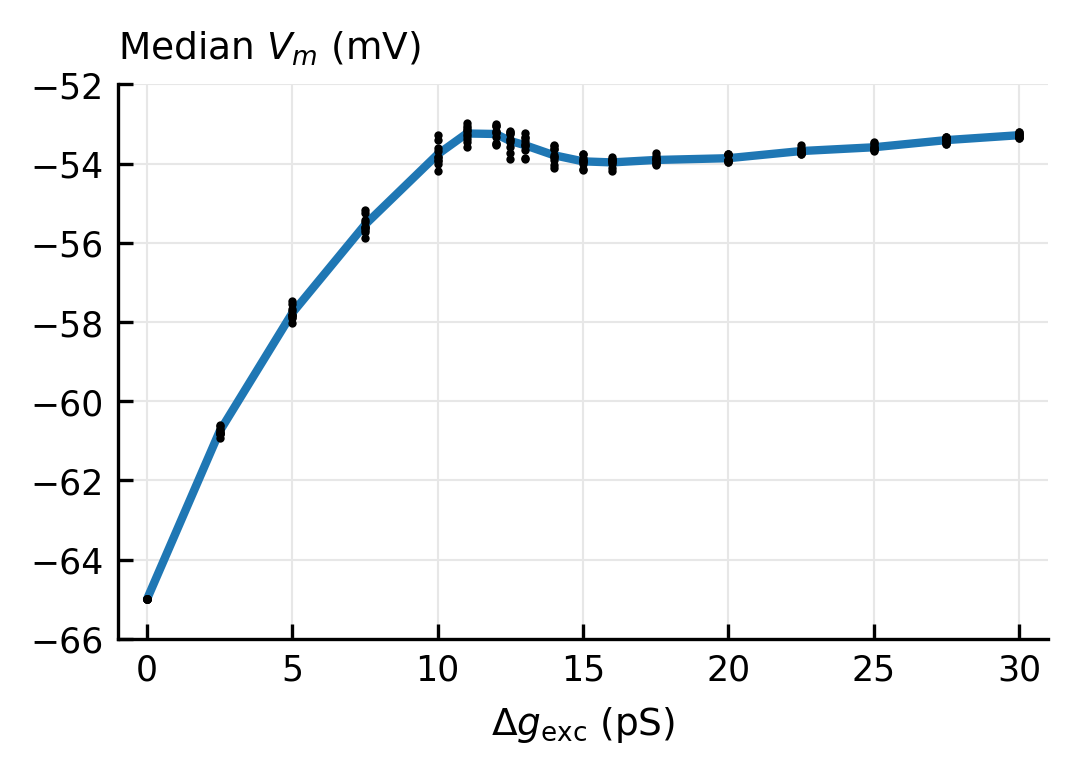

In [39]:
def plot_dots_and_means(x, y, ax = None):
    if ax is None:
        fig, ax = plt.subplots()
    xu = unique(x)
    ym = [mean(y[x == xi]) for xi in xu]
    ax.plot(xu, ym, "-", lw=2)
    ax.plot(x, y, "k.", ms=4, mfc='k', mec='none')
    
fig, ax = plt.subplots()
plot_dots_and_means(df.we_pS, df.median_Vm_mV, ax)
hylabel(ax, "Median $V_m$ (mV)")
xl = "$Δg_\\mathrm{exc}$ (pS)"
plt.xlim(-1, 31)
plt.xlabel(xl);

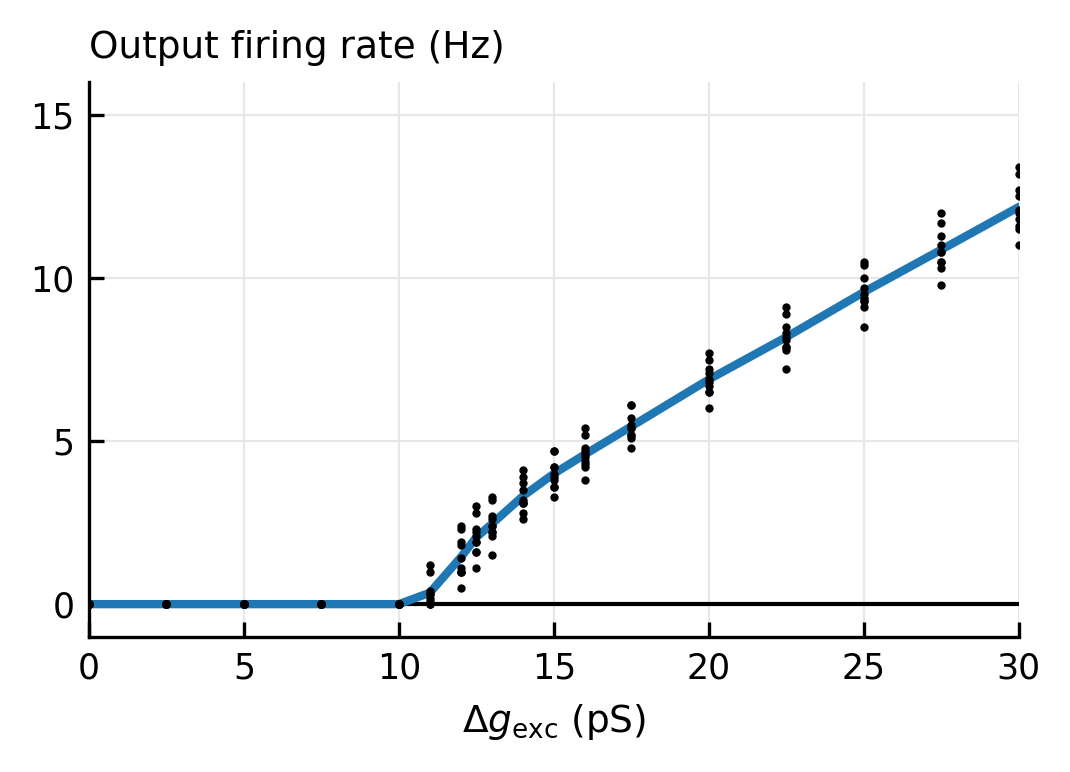

In [40]:
fig, ax = plt.subplots()
plt.axhline(0, 0, 1, c="black", lw=1)
plot_dots_and_means(df.we_pS, df.output_rate_Hz, ax)
hylabel(ax, "Output firing rate (Hz)")
plt.ylim(-1, 16)
plt.xlabel(xl);

Saved at `../thesis/figs/input_drive_we.pdf`


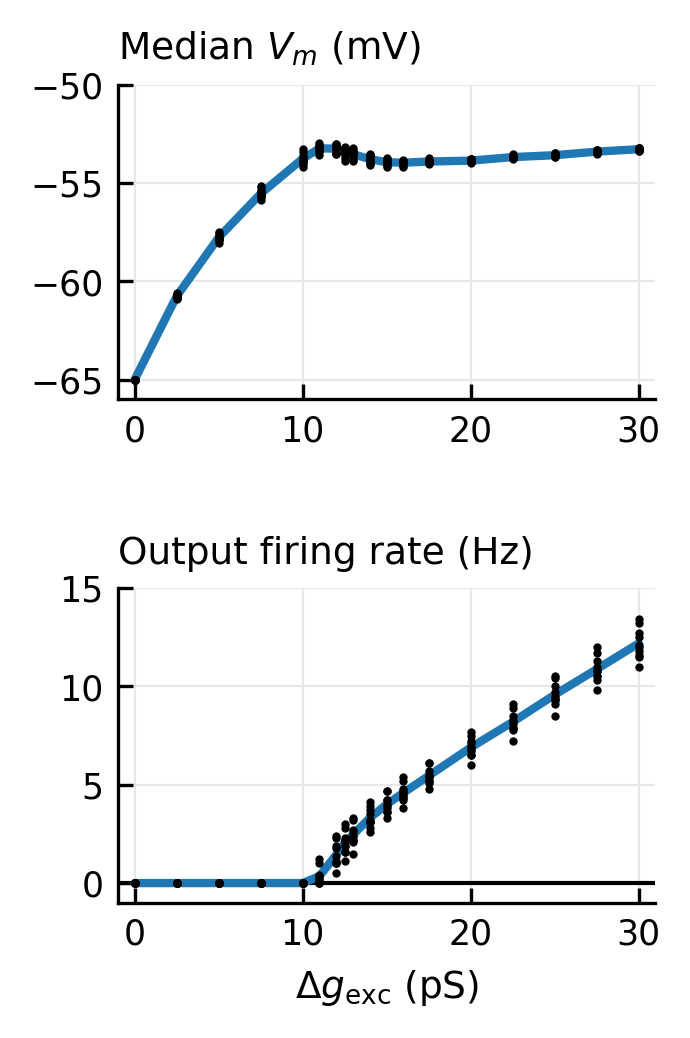

In [45]:
fig, axs = plt.subplots(figsize=(2.4, 3.4), nrows=2)
axs[1].axhline(0, 0, 1, c="black", lw=1)
plot_dots_and_means(df.we_pS, df.median_Vm_mV, axs[0])
plot_dots_and_means(df.we_pS, df.output_rate_Hz, axs[1])
axs[1].set_ylim(-1, 15)
axs[1].set_xlim(-1, 31)
axs[0].set_xlim(-1, 31)
axs[0].set_ylim(-66, -50)
hylabel(axs[0], "Median $V_m$ (mV)")
hylabel(axs[1], "Output firing rate (Hz)")
plt.tight_layout(h_pad=2)
axs[1].set_xlabel(xl);
savefig_thesis("input_drive_we")